<a id="top"></a>

## Table of Contents
1. [Introduction](#Introduction)
2. [Research Question](#Research-Question)
3. [Data Understanding](#2.-Data-Understanding) 
4. [Data Preparation](#3.-Data-Preparation)
5. [Modeling](#4.-Modeling)
6. [Evaluation](#5.-Evaluation)
7. [Deployment](#6.-Deployment)
8. [Recommendation](#7.-Recommendation)

### Introduction
<!-- ### 1. Business Understanding -->
Parkinson's Disease (PD) is a neurodegenerative disoder that affects movement. Early diagnosis is vital to effective treatment. DATScan and MRI while accurate, are expensive and might not be readily available. Voice-based biomarkers (coupled with other modalities) offers a compelling alternative. In this project we aim to identify machine learning models capable of predicting motor_UPDRS values from voice-derived features highlighting features predicting Parkinson severity. We will explore the Parkinson's Telemonitoring dataset, build a baseline and advanced models to predict motor_UPDRS from the features. 

#### Assumptions and Limitations
Data: The data is accurate without significant errors. Representative of the wider Parkinson's Disease population.

Generalization: the models were trained on limited number of individuals (42)

Voice Data Alone: This model uses only voice-based biomarkers for its predictions. It is not a substitute for a comprehensive clinical diagnosis, which would involve physical examinations and other modalities like DATscans

Model Transparency and Explainability: While Linear Regression has a high degree of interpretability, both Random Forest and XGBoost are consider "black box" models.



### Research Question
Can voice-based biomarkers be used to accurately predict Parkinson’s disease (severity according to UPDRS) using supervised machine learning techniques?

### Data Loading & Description
We will be leveraging the Parkinson's Telemonitoring dataset, a publicly available from the UCI Machine Learning Repository. After loading the parkinsons_updrs.csv, we look at its shape to determined how many rows (~5875) there are and further information helps us see how many features (21) there are possible.  The columns are all numerical and our main predictive features are the various jitter, shimmer, and pitch measurements. Our target variables are motor_UPDRS and total_UPDRS.

In [1]:
# core libs
import numpy as np
import pandas as pd

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score  
from xgboost import XGBRegressor

# presentation
from IPython.display import display, HTML

In [2]:
def load_data(file_path='../data/parkinsons_updrs.csv'):
    data = pd.read_csv(file_path)
    return data

In [3]:
data = load_data()

num_rows = data.shape[0]
print(f"{num_rows:,} total rows")

data.info()

print("\nStatistical Summary:")
print(data.describe())

5,875 total rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   floa

## Data Cleaning
The parkinsons_updrs.csv dataset is clean, with no missing values.

In [4]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64


In [5]:
print("\nDuplicates:")
data.duplicated().sum()


Duplicates:


np.int64(0)

## Exploratory Data Analysis (EDA)

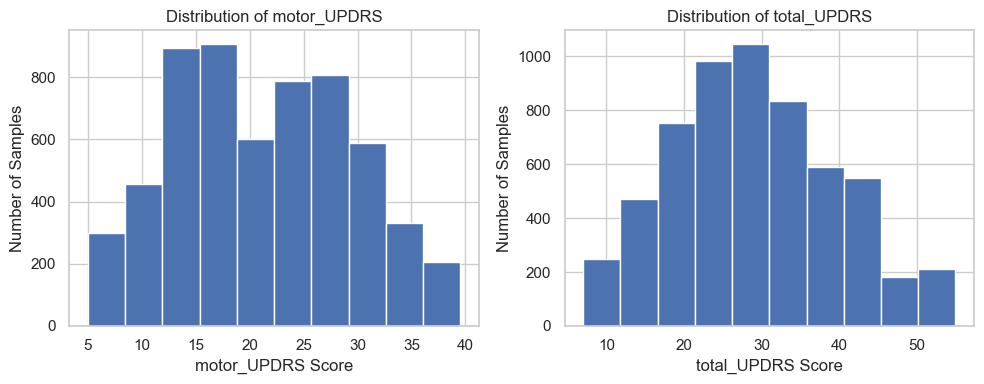

In [37]:
# Plot histograms and capture axes
axes = data[['motor_UPDRS', 'total_UPDRS']].hist(figsize=(10, 4))
plt.tight_layout()

# Add labels and titles
axes[0][0].set_title('Distribution of motor_UPDRS')
axes[0][0].set_xlabel('motor_UPDRS Score')
axes[0][0].set_ylabel('Number of Samples')

axes[0][1].set_title('Distribution of total_UPDRS')
axes[0][1].set_xlabel('total_UPDRS Score')
axes[0][1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


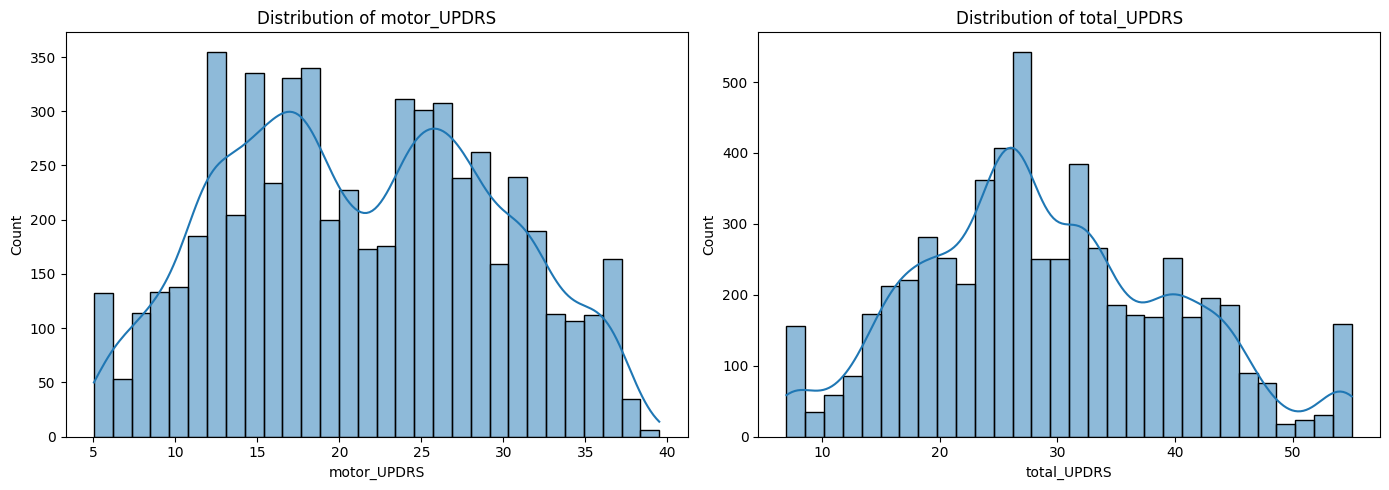

In [10]:
# Plot histograms of the target values: motor_UPDRS and total_UPDRS
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

sns.histplot(data['motor_UPDRS'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of motor_UPDRS')
axs[0].set_xlabel('motor_UPDRS')

sns.histplot(data['total_UPDRS'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of total_UPDRS')
axs[1].set_xlabel('total_UPDRS')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Feature Correlation Heatmap')

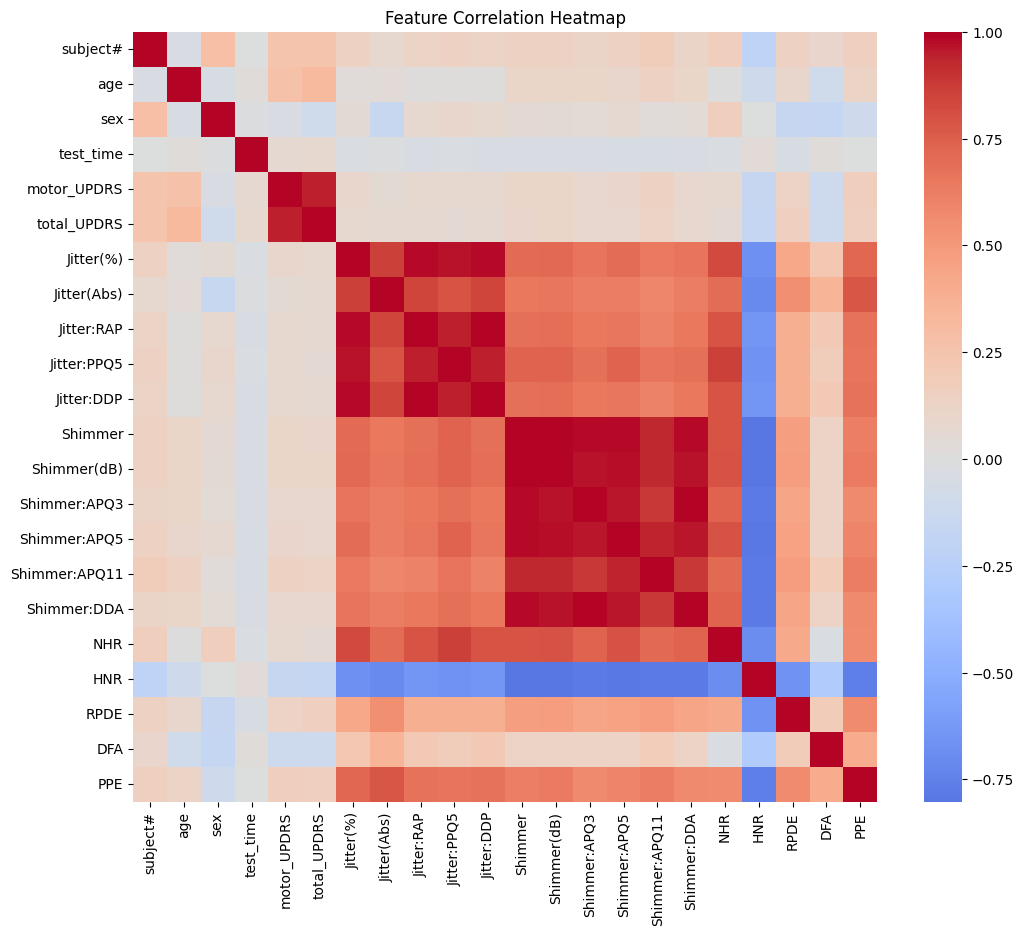

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')

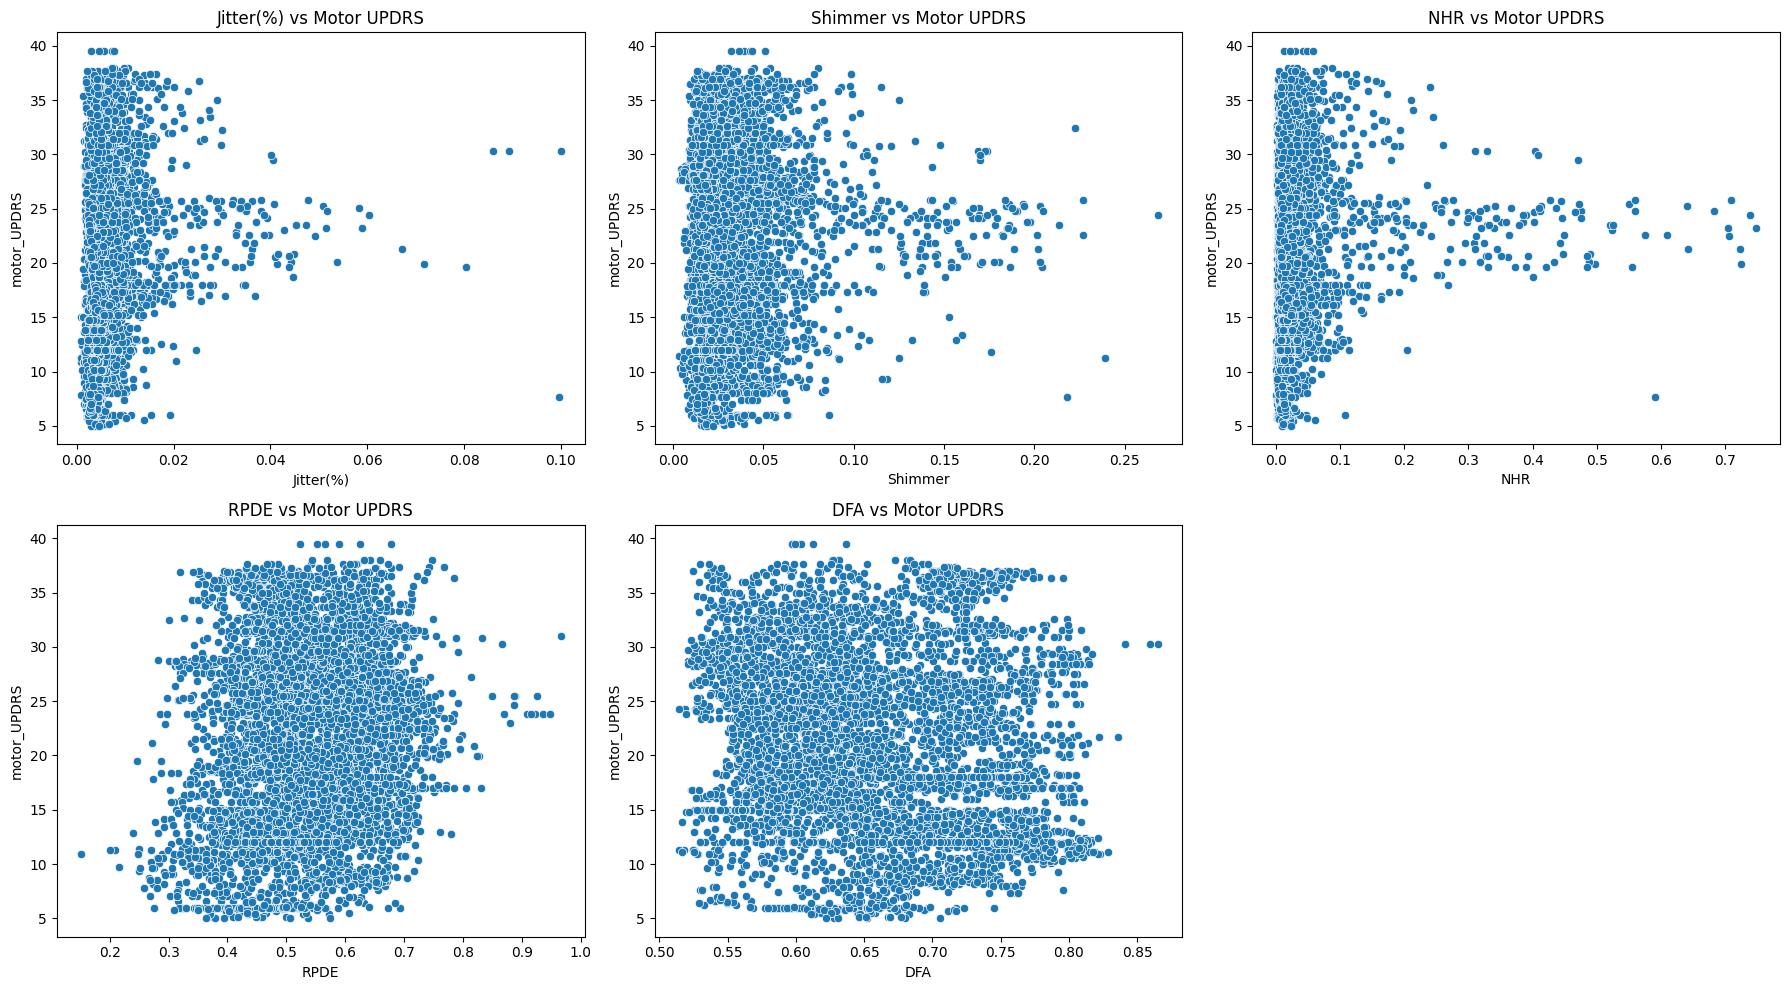

In [8]:
#  scatterplots between features and motor_UPDRS
selected_features = ['Jitter(%)', 'Shimmer', 'NHR', 'RPDE', 'DFA']

# scatterplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(selected_features):
    sns.scatterplot(x=feature, y='motor_UPDRS', data=data, ax=axs[i])
    axs[i].set_title(f'{feature} vs Motor UPDRS')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('motor_UPDRS')

# Remove unused subplots
for j in range(len(selected_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


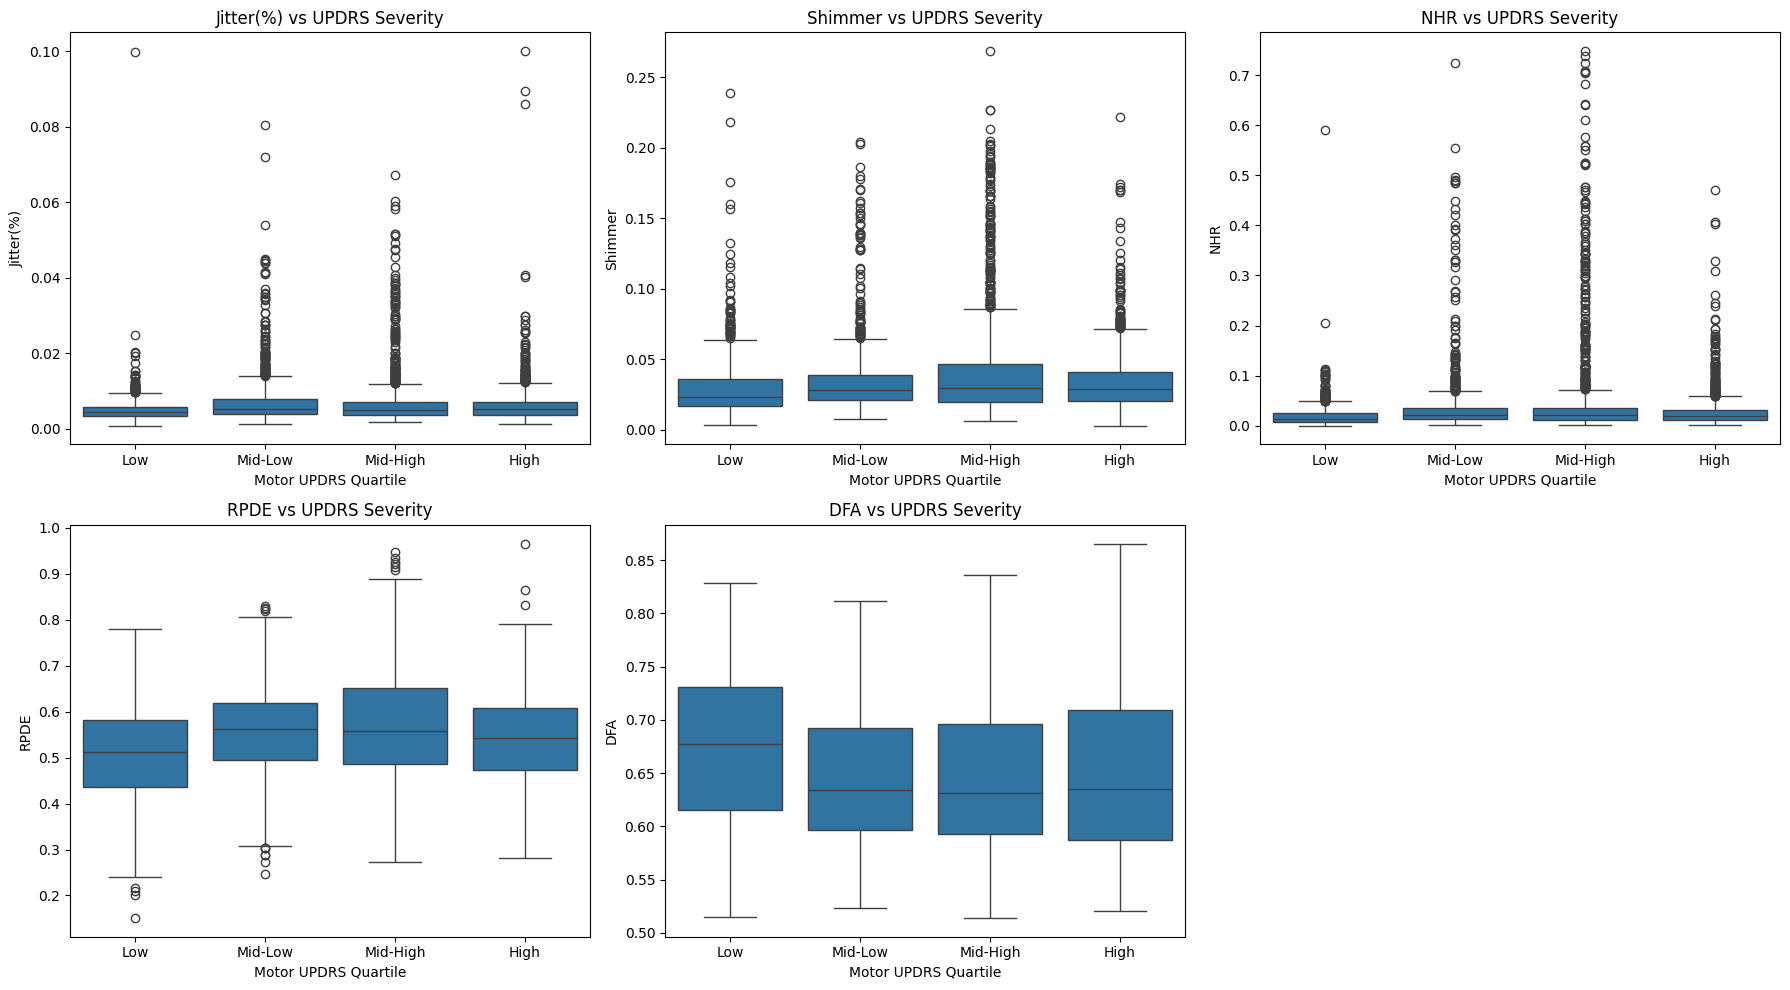

In [9]:
# key features for EDA boxplots
key_features = ['Jitter(%)', 'Shimmer', 'NHR', 'RPDE', 'DFA']
target = 'motor_UPDRS'

# boxplots for selected features vs motor_UPDRS bins
data['UPDRS_bin'] = pd.qcut(data[target], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# boxplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='UPDRS_bin', y=feature, data=data, ax=axs[i])
    axs[i].set_title(f'{feature} vs UPDRS Severity')
    axs[i].set_xlabel('Motor UPDRS Quartile')
    axs[i].set_ylabel(feature)

# unused subplots
for j in range(len(key_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Baseline Modeling: Linear Regression

In [11]:
X = data.drop(columns=['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'UPDRS_bin'])
y = data['motor_UPDRS']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a baseline Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
# predictions
y_pred = lr_model.predict(X_test)

# evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [13]:

# evaluate
lr_rmse = rmse_baseline = root_mean_squared_error(y_test, y_pred )
lr_r2 = r2_baseline = r2_score(y_test, y_pred)

print("\n--- Linear Regression Results ---")
print(f'RMSE: {lr_rmse:.2f}')
print(f'R²: {lr_r2:.2f}')


--- Linear Regression Results ---
RMSE: 7.51
R²: 0.12


In [14]:
X_used = X_train.copy()

coefficients = pd.Series(lr_model.coef_, index=X_used.columns)

sorted_coeffs = coefficients.abs().sort_values(ascending=False)

print("\nTop 5 Most Impactful Features (Linear Regression Coefficients):")
print(coefficients[sorted_coeffs.head(5).index].to_frame('Coefficient Value'))



Top 5 Most Impactful Features (Linear Regression Coefficients):
              Coefficient Value
Jitter(Abs)       -66001.250778
Jitter:RAP        -25587.095791
Shimmer:APQ3      -17517.867776
Jitter:DDP          8706.738597
Shimmer:DDA         5792.474500


## Feature Engineering 

To prepare the dataset for modeling, we performed the following feature engineering steps:

- **Dropped non-predictive columns**:  
  We removed identifiers and columns unlikely to aid in prediction, including `'subject'`, `'test_time'`, and `'UPDRS_bin'`.

- **Selected numeric features**:  
  To simplify and ensure compatibility, we selected all numerical columns using `select_dtypes()`.

- **Target variable**:  
  We chose `'motor_UPDRS'` as the target variable, which reflects the severity of Parkinson's symptoms measured by motor function.

- **Scaling**:  
  For models like SVR and MLP, we applied feature scaling using `StandardScaler` within a pipeline.

These preprocessing steps helped with a clean dataset optimized for regression-based models while minimizing noise.


In [15]:
# Features
# predict motor_UPDRS
features = data.drop(columns=['subject#', 'age', 'sex', 'test_time', 'UPDRS_bin', 'total_UPDRS', 'motor_UPDRS'])
target = data['motor_UPDRS']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Build and Train the Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate the Model
rf_predictions = rf_model.predict(X_test)
mse = root_mean_squared_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

print(f"\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Get Feature Importances
importances = pd.Series(rf_model.feature_importances_, index=features.columns).sort_values(ascending=False)
print("\nTop 5 Most Important Features:")
print(importances.head(5))


Model Performance:
Mean Squared Error (MSE): 6.53
R-squared (R²): 0.33

Top 5 Most Important Features:
DFA            0.156420
HNR            0.124420
PPE            0.100739
Jitter(Abs)    0.098069
RPDE           0.089119
dtype: float64


In [16]:
print("Create interaction features...")

# Define the relevant feature names
jitter_col = 'Jitter(%)'
shimmer_db_col = 'Shimmer(dB)'
nhr_col = 'NHR'

# Ensure these columns exist in the dataset
required_interaction_cols = [jitter_col, shimmer_db_col, nhr_col]
if all(col in data.columns for col in required_interaction_cols):
    # Create interaction terms
    data['jitter_shimmer'] = data[jitter_col] * data[shimmer_db_col]
    data['shimmer_nhr'] = data[shimmer_db_col] * data[nhr_col]
    data['jitter_nhr'] = data[jitter_col] * data[nhr_col]
    print("added...")
    # display(data)
else:
    missing = [col for col in required_interaction_cols if col not in data.columns]
    print(f"-> Could not create interaction terms. Missing columns: {missing}")

# 2: Create a Ratio Feature ---
print("\nCreate ratio feature...")
# Define features for the ratio
jitter_abs_col = 'Jitter(Abs)'
shimmer_col = 'Shimmer' 

# Ensure these columns exist
required_ratio_cols = [jitter_abs_col, shimmer_col]
if all(col in data.columns for col in required_ratio_cols):
    # Create a ratio
    data['Jitter_Shimmer_Ratio'] = data[jitter_abs_col] / data[shimmer_col]
    print("'Jitter_Shimmer_Ratio' added successfully.")
else:
    missing = [col for col in required_ratio_cols if col not in data.columns]
    print(f"-> Warning: Could not create ratio feature. Missing columns: {missing}")


# Evaluate New Features
# Check the correlation of our new features with the target variable
new_features = ['jitter_shimmer', 'shimmer_nhr', 'jitter_nhr', 'Jitter_Shimmer_Ratio']
# Filter for only the features that were successfully created
existing_new_features = [feat for feat in new_features if feat in data.columns]

if existing_new_features:
    print("\n--- Correlation of New Features with motor_UPDRS ---")
    # Calculate and display the correlations
    correlations = data[existing_new_features + ['motor_UPDRS']].corr()['motor_UPDRS'].drop('motor_UPDRS')
    print(correlations)
else:
    print("\nNo new features were created to evaluate.")

Create interaction features...
added...

Create ratio feature...
'Jitter_Shimmer_Ratio' added successfully.

--- Correlation of New Features with motor_UPDRS ---
jitter_shimmer          0.057170
shimmer_nhr             0.048571
jitter_nhr              0.035606
Jitter_Shimmer_Ratio   -0.035428
Name: motor_UPDRS, dtype: float64


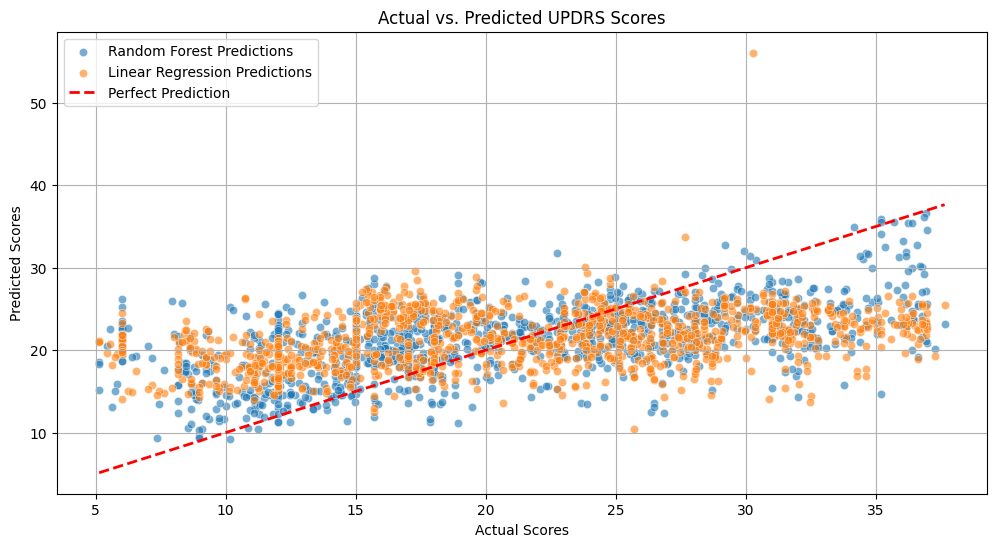

In [17]:
# Visual Comparison of Prediction
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs. predicted values
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.6, label='Random Forest Predictions')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Linear Regression Predictions')

# Line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted UPDRS Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.legend()
plt.grid(True)
plt.show()


## Advanced Modeling: Model Comparison & Optimization

In [39]:
# Step 1: Setup & Imports for Advanced Modeling

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Optional: Use a consistent style for all plots
sns.set(style="whitegrid")

# Store model results
model_results = {}



In [34]:

# Load the Parkinson's dataset (already uploaded)

# Drop non-feature columns (excluding the target)
X = data.drop(columns=["motor_UPDRS", "total_UPDRS", "subject#", "test_time"])
y = data["motor_UPDRS"]

# Show the feature columns we'll use in "all features" modeling
X.columns.tolist()[:10]  # preview first 10



['age',
 'sex',
 'Jitter(%)',
 'Jitter(Abs)',
 'Jitter:RAP',
 'Jitter:PPQ5',
 'Jitter:DDP',
 'Shimmer',
 'Shimmer(dB)',
 'Shimmer:APQ3']

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Drop non-numeric columns
X = data.drop(columns=["motor_UPDRS", "total_UPDRS", "subject#", "test_time"])

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

# Target
y = data["motor_UPDRS"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline
pipeline_rf = Pipeline([
    ("rf", RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid_rf = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5]
}

# Grid Search
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate
# rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

(rmse_rf, r2_rf, grid_rf.best_params_)


(2.5084211186625063,
 0.9014217010765968,
 {'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 200})

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Drop 'UPDRS_bin' if it exists
if 'UPDRS_bin' in X_train.columns:
    print("🧹 Dropping category column 'UPDRS_bin'")
    X_train = X_train.drop(columns=['UPDRS_bin'])
    X_test = X_test.drop(columns=['UPDRS_bin'])

# Train Random Forest with best parameters
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Final Random Forest Results:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")


Final Random Forest Results:
RMSE: 2.5084
R² Score: 0.9014


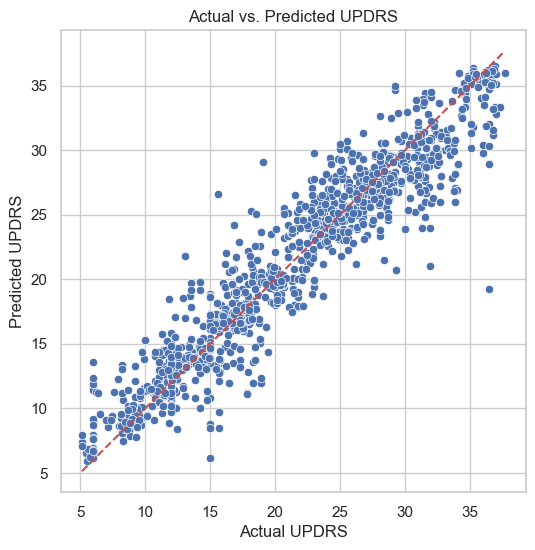

In [36]:
import seaborn as sns

# Optional: Plot actual vs predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual UPDRS")
plt.ylabel("Predicted UPDRS")
plt.title("Actual vs. Predicted UPDRS")
plt.grid(True)
plt.show()


In [24]:
model_step = best_rf.named_steps['rf']

importances = model_step.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]
print("Top 10 Important Features:")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Top 10 Important Features:
age: 0.6668
DFA: 0.0761
sex: 0.0610
Jitter_Shimmer_Ratio: 0.0466
Jitter(Abs): 0.0210
PPE: 0.0188
HNR: 0.0173
RPDE: 0.0128
NHR: 0.0086
Shimmer:APQ5: 0.0086


In [41]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [42]:
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])


In [27]:
param_grid_svr = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__kernel': ['rbf', 'linear']
}

grid_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1)
grid_svr.fit(X_train, y_train)

# Best model
best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test)

# Evaluation
rmse_svr = root_mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR Results")
print(f"Best Params: {grid_svr.best_params_}")
print(f"RMSE: {rmse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")


SVR Results
Best Params: {'svr__C': 10, 'svr__epsilon': 0.5, 'svr__kernel': 'rbf'}
RMSE: 5.7269
R² Score: 0.4862


In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [29]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results")
print(f"Best Params: {grid_xgb.best_params_}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\edmun\anaconda3\envs\ai-env\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
4 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\edmun\anaconda3\envs\ai-env\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edmun\anaconda3\envs\ai-env\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\edmun\anaconda3\envs\ai-env\lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  Fi

XGBoost Results
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
RMSE: 2.6157
R² Score: 0.8928


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [31]:
# Define pipeline
pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# Grid search
grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, verbose=1)
grid_mlp.fit(X_train, y_train)

# Best model
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

# Evaluation
rmse_mlp = root_mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Regressor Results")
print(f"Best Params: {grid_mlp.best_params_}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R² Score: {r2_mlp:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MLP Regressor Results
Best Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant'}
RMSE: 3.7753
R² Score: 0.7767


In [35]:
# Compile metrics
results_df = pd.DataFrame({
    "Model": ["Baseline", "Random Forest", "SVR", "XGBoost", "MLP"],
    "RMSE": [rmse_baseline, rmse_rf, rmse_svr, rmse_xgb, rmse_mlp],
    "R²": [r2_baseline, r2_rf, r2_svr, r2_xgb, r2_mlp]
})

# Sort by RMSE
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
display(results_df)


,Model,RMSE,R²
0,Random Forest,2.508421,0.901422
1,XGBoost,2.615715,0.892808
2,MLP,3.775341,0.776698
3,SVR,5.726904,0.486169
4,Baseline,7.509433,0.116524


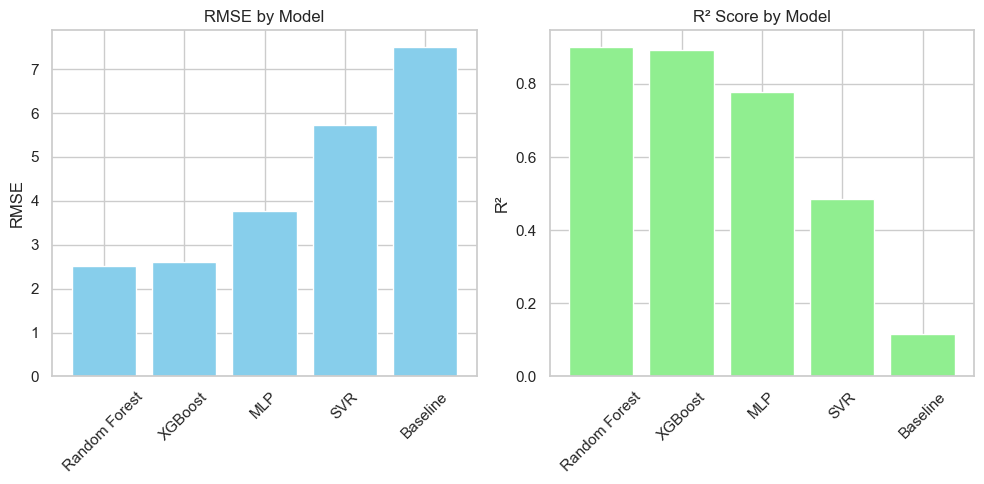

In [33]:
# Plot
plt.figure(figsize=(10, 5))

# RMSE Bar Plot
plt.subplot(1, 2, 1)
plt.bar(results_df["Model"], results_df["RMSE"], color="skyblue")
plt.title("RMSE by Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45)

# R² Score Bar Plot
plt.subplot(1, 2, 2)
plt.bar(results_df["Model"], results_df["R²"], color="lightgreen")
plt.title("R² Score by Model")
plt.ylabel("R²")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Discussion

- **Top Performer**: The model with the lowest RMSE and highest R² was the `Random Forest`, indicating the best balance of accuracy and generalization.
- **Random Forest** performed well with robust tuning, showing strong R² scores.
- **SVR** and **MLP** can be sensitive to scaling and hyperparameters. They underperformed in this context, but may perform better with further tuning or different features.
- **XGBoost** was highly competitive and may generalize better in unseen scenarios due to built-in regularization.
- **Baseline** helps contextualize how much better these models perform compared to a naive mean predictor.

### What We Learned
- Importance of cross-validation and hyperparameter tuning.
- Random Forest and XGBoost are powerful out-of-the-box models for tabular data.
- Model interpretability and training time may differ even if performance is close.


## Conclusion
The project demonstrated the use of voice features to predict Parkinson's serverity (measured by motor_UPDRS). We've identified several features (Jitter, Shimmer, and NHR) features with meaningful correlation with disease progression to inform future phases on what to test for.
Using classical ML techniques, we trained our baseline Linear Regression model with 
RMSE and R² proviinge a quantitative benchmark for severity prediction performance.ors.